In [1]:
import nengo
from nengo.utils.compat import is_number
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Choice
from nengo.dists import Uniform
from nengo.utils.functions import piecewise
from nengo.utils.matplotlib import rasterplot
from nengo.networks import InputGatedMemory


import nengo_gui
from nengo_gui.ipython import IPythonViz

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("paper")

import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['legend.fontsize'] = 15

### Highpass Synapse Model

In [2]:
def highpass(tau, order=1):
    """Differentiated lowpass, raised to a given power."""
    if order < 1 or not is_number(order):
        raise ValueError("order (%s) must be integer >= 1" % order)
    num, den = map(np.poly1d, ([tau, 0], [tau, 1]))
    return nengo.LinearFilter(num**order, den**order)

### MMN
Using variation in intensity of the stimulus as an oddball.

In [17]:
flag = 0  # 1 for dev, 0 for std

# Setup the experiment

dev_trials = []
std_trials = []

isi = 500.0/1000.0          # inter-stimulus interval
stim_dur = 200.0/1000.0       # stimulus duration
trial_len = isi + stim_dur  # length of each trial

prestimulus_baseline = 0.1  # 100 ms  -  this can also be set to 0
remove_beg = int((trial_len - prestimulus_baseline) * 1000)  # remove this much ms of stimulus from the beginning

class Experiment(object):
    def __init__(self, seed=None, isi=isi, stim_dur=stim_dur, std_value=0.4, dev_value=0.8, trial_len=trial_len, 
                                                                            prestim_baseline=prestimulus_baseline):
        self.rng = np.random.RandomState(seed=seed)
        self.prestim_baseline = prestim_baseline
        self.isi = isi
        self.stim_dur = stim_dur
        self.trial_len = trial_len
        self.std_value = std_value
        self.dev_value = dev_value
        self.prev_rise = 0
        self.stim_value = 0
        self.trial_number = 0
        self.inhib = 0
        self.reset = 0
        self.gate = 1
    
    # provide stimulus for each trial and keep
    # track of deviant and standard trials
    def stimulus_in(self, t):         
        # pull up the value to 0.4 or 0.8
        if int(t*1000) % int(self.trial_len*1000) == 0:
            self.trial_number = self.trial_number+1 # increment the trial counter
            self.prev_rise = t
            self.inhib = 0
            self.stim_value = np.random.choice((self.std_value, self.dev_value), p=(0.8, 0.2))                          
            if self.stim_value == self.dev_value:
                dev_trials.append(self.trial_number)    # store the trial numbers of oddballs
                flag = 1
            elif self.stim_value == self.std_value:
                std_trials.append(self.trial_number)
                flag = 0
            self.reset = 0    
            self.gate = 0   # open the gate/channel to memory       
            return self.stim_value
        # pull down the value - bring it back to 0
        elif int(t*1000) == (int (self.prev_rise*1000) + self.stim_dur*1000):
            self.stim_value = 0
            self.gate = 1   # close the gate/channel to memory 
            return self.stim_value
        return self.stim_value
    
    
    def inhibit_in(self, t):
        if int(t*1000) % (int(self.trial_len*1000)-int(self.prestim_baseline*1000)) == 0:
            self.inhib = 1
            self.reset = 1
        return self.inhib
        
    def gate_in(self, t):
        return self.gate
    
    def reset_in(self, t):
        return self.reset
    

In [18]:
# Build nengo model

tau_highpass = 0.5

seed=12
num_neurons = 200
dim = 1
model = nengo.Network(seed=seed)
with model:
    
    exp = Experiment(seed=seed)
    stim = nengo.Node(exp.stimulus_in)
    stim_inhib = nengo.Node(exp.inhibit_in)
  
    # create the ensemble with added noise at the input of each neuron
    result = nengo.Ensemble(n_neurons=num_neurons, dimensions=dim, noise=nengo.processes.BrownNoise()) 
    nengo.Connection(stim, result, synapse=highpass(tau_highpass))
    nengo.Connection(stim_inhib, result.neurons, transform=[[-2.5]]*result.n_neurons) # inhibit result during 
                                                                                        # prestimulus period
    
    # create input gated memory to store previous trial stimulus
    mem = InputGatedMemory(n_neurons=100, dimensions=1, recurrent_synapse=0.2, difference_gain=1.0)
    nengo.Connection(result, mem.input)
    stim_gate = nengo.Node(exp.gate_in)
    nengo.Connection(stim_gate, mem.gate)
    stim_reset = nengo.Node(exp.reset_in)
    nengo.Connection(stim_reset, mem.reset)
    
    # add a controlled integrator
    # testing feedback:
    # feedback from mem in case of deviants during ISI before prestimulus interval
    def route(x):
        if flag == 1: # deviant:
            return x*1
        else:
            return x*0  # if standard
        
    dev_amp = nengo.Ensemble(n_neurons=num_neurons, dimensions=dim, noise=nengo.processes.BrownNoise())
    nengo.Connection(mem.output, dev_amp)
    nengo.Connection(dev_amp, result, function=route)
    
    
    
    # probes
    stim_p = nengo.Probe(stim, synapse=None)
    result_p = nengo.Probe(result, synapse=0.03)
    p_mem = nengo.Probe(mem.output, synapse=0.03)
     

sim = nengo.Simulator(model)
sim.run(6*60)   # run for 10 minutes 

Building finished in 0:00:01.                                                   
Simulating finished in 0:03:56.                                                 


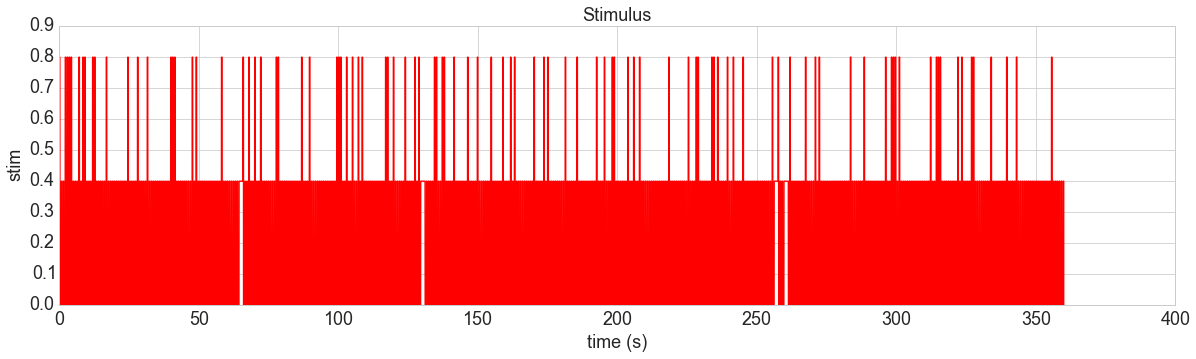

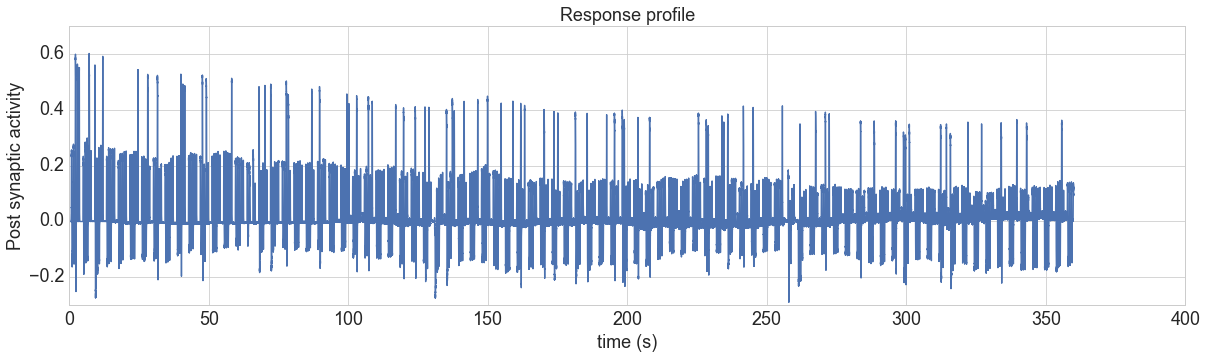

In [19]:
# plot the stimulus and response
t = sim.trange()

plt.figure(figsize=(20,5))
plt.plot(t, sim.data[stim_p], 'r')
plt.ylabel("stim")
plt.xlabel("time (s)")
plt.title("Stimulus")
#plt.xlim(0, 3)

plt.figure(figsize=(20,5))
plt.plot(t, sim.data[result_p])
plt.ylabel("Post synaptic activity")
plt.xlabel("time (s)")
plt.title("Response profile")     
#plt.xlim(350, 360)

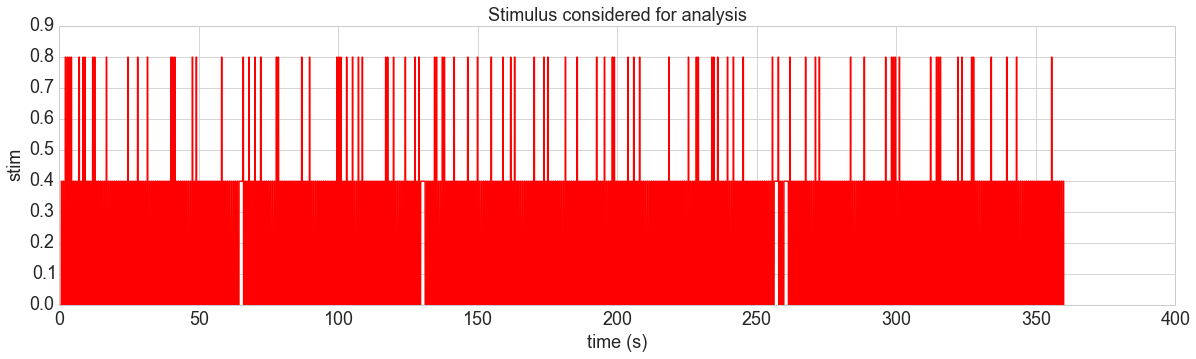

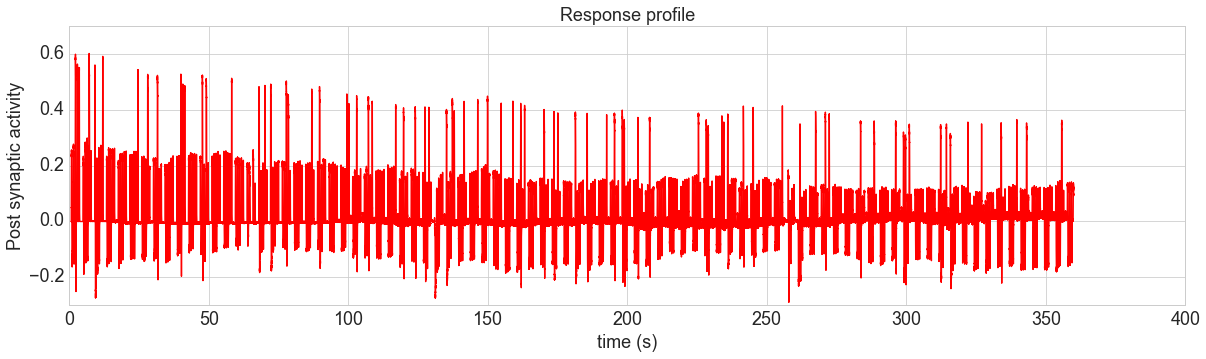

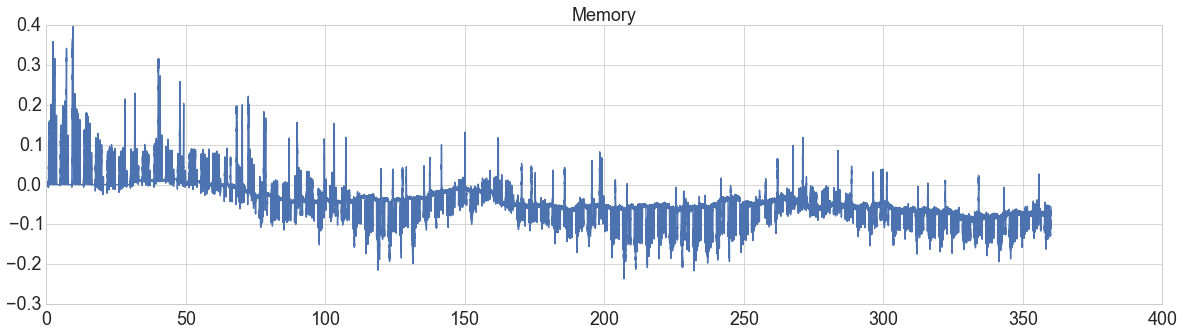

In [20]:
# stimulus profile after removing the first stimulus
# and adding the pre-stimulus baseline
test = sim.data[stim_p]
test = test[remove_beg:] 
plt.figure(figsize=(20,5))
plt.plot(t[remove_beg:], test, 'r')
plt.ylabel("stim")
plt.xlabel("time (s)")
plt.title("Stimulus considered for analysis")
#plt.xlim(0, 3)


test = sim.data[result_p]
test = test[remove_beg:] 
plt.figure(figsize=(20,5))
plt.plot(t[remove_beg:], test, 'r')
plt.ylabel("Post synaptic activity")
plt.xlabel("time (s)")
plt.title("Response profile") 
#plt.xlim(0, 3)


# this needs inhibition to work
# otherwise the previous trial stimuli effect  
# the values store in memory in the current trial
plt.figure(figsize=(20,5))
plt.plot(sim.trange(), sim.data[p_mem])
plt.title("Memory")
plt.show()

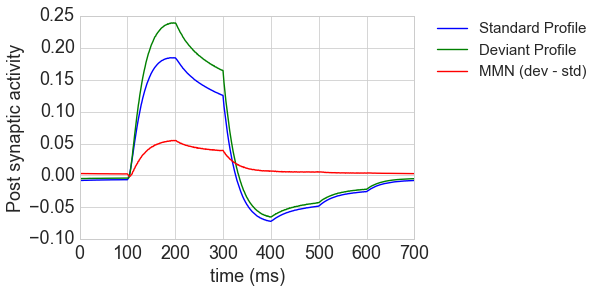

In [22]:
# Post Processing to get mmn

data = sim.data[result_p]
data = data[remove_beg:]   # remove the first trial

num_trials = int(np.floor(len(data) / float(trial_len*1000)))
trial_data = data[:num_trials*int(trial_len*1000)]
#print "Number of deviant trials: ", len(dev_trials)
#print "Number of standard trials: ", len(std_trials)
#print dev_trials
#print std_trials

# remove the first and the last (unfinished trial)
for x in dev_trials:
    if x>num_trials or x == 1:
        dev_trials.remove(x)

for y in std_trials:        
    if y>num_trials or x == 1:
        std_trials.remove(y)

#print "Number of trials: ", num_trials
#print "Number of deviant trials: ", len(dev_trials)
#print "Number of standard trials: ", len(std_trials)

trial_data = trial_data.reshape(num_trials, int(trial_len*1000))
dev_data = trial_data[np.where(dev_trials)]
std_data = trial_data[np.where(std_trials)]

#print len(dev_data)
#print len(std_data)

avg_dev_data = np.average(dev_data, axis=0)
avg_std_data = np.average(std_data, axis=0)

mmn = avg_dev_data-avg_std_data

plt.figure()
plt.plot(range(int(trial_len*1000)), avg_std_data, 'b')
plt.plot(range(int(trial_len*1000)), avg_dev_data, 'g')
plt.plot(range(int(trial_len*1000)), mmn, 'r')
plt.ylabel("Post synaptic activity")
plt.xlabel("time (ms)")
plt.legend(["Standard Profile","Deviant Profile","MMN (dev - std)"] , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

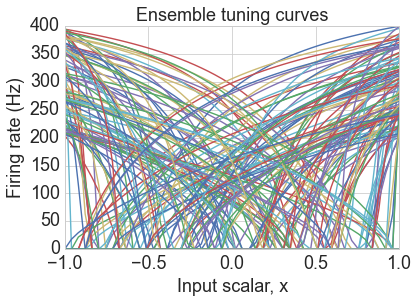

In [8]:
# plot ensemble tuning curves
with sim:
    plt.figure()
    plt.plot(*tuning_curves(result, sim))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input scalar, x")
    plt.title("Ensemble tuning curves")

In [ ]:
IPythonViz(model)